## Chapter 23 Moving Average Models for Forecasting

The **residual errors** from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a **moving average model**,
the same name but very diﬀerent from moving average smoothing.

#### Model of Residual Errors

The difference between what was expected and what was predicted is called the residual error: residual_error = expected - predicted.

Just like the input observations themselves, *the residual errors from a time series can have temporal structure like trends, bias, and seasonality*. Any temporal structure in the time series of residual forecast errors is useful as a diagnostic as it suggests information that could be incorporated into the predictive model. An ideal model would leave no structure in the residual
error, just random fluctuations that cannot be modeled.

Structure in the residual error can also be modeled directly. There may be complex signals in the residual error that are diﬃcult to directly incorporate into the model. Instead, you can create a model of the residual error time series and predict the expected error for your model. The predicted error can then be subtracted from the model prediction and in turn provide an additional lift in performance.

A simple and eﬀective model of residual error is an autoregression.
**An autoregression of the residual error time series is called a Moving
Average (MA) model**. This is confusing because it has nothing to do with the moving average smoothing process. Think of it as the sibling to the autoregressive (AR) process, except on lagged residual error rather than lagged raw observations.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [3]:
series = pd.read_csv('data/daily-total-female-births.csv', index_col=0, parse_dates=True)
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


#### Persistence Forecast Model

The simplest forecast that we can make is to forecast that what happened in the previous time step will be the same as what will happen in the next time step. This is called the naive forecast
or the persistence forecast model. This model will provide the predictions from which we can calculate the residual error time series. No training is required for the persistence model; this is just a standard test harness approach.

In [5]:
# create lagged dataset
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:, 0], train[:, 1]
test_X, test_y = test[:, 0], test[:, 1]
# persistence model
predictions = [x for x in test_X]
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f'Test RMSE: {rmse:.3f}')
# calculate residuals
residuals = [test_y[i] - predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.head()

Test RMSE: 9.151


,0
0,9.0
1,-10.0
2,3.0
3,-6.0
4,30.0


#### Autoregression of Residual Error

We can model the residual error time series using an autoregression model. This is a linear regression model that creates a weighted linear sum of lagged residual error terms.

we can first train the model on the residual errors calculated on the training dataset. This requires that we make persistence predictions for each observation in the training dataset, then create the AR model, as follows.

Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]
predicted error=1.1555234505436354, expected error=9.0
predicted error=-7.10880932851303, expected error=-10.0
predicted error=3.0074862952616215, expected error=3.0
predicted error=-0.756445653282735, expected error=-6.0
predicted error=5.511162863062307, expected error=30.0
predicted error=-19.99126358972993, expected error=-28.0
predicted error=4.84242886199457, expected error=2.0
predicted error=3.0508830541985783, expected error=9.0
predicted error=-5.141585338791695, expected error=-7.0
predicted error=1.161119158559183, expected error=1.0
predicted error=-0.24192844431556543, expected error=-9.0
predicted error=9.159826043597475, expected error=21.0
predicted error=-7.11797367388566, expected error=-13.0
predicted error=1.1829921745309908, expected error=-2.0
predicted error=2.7693

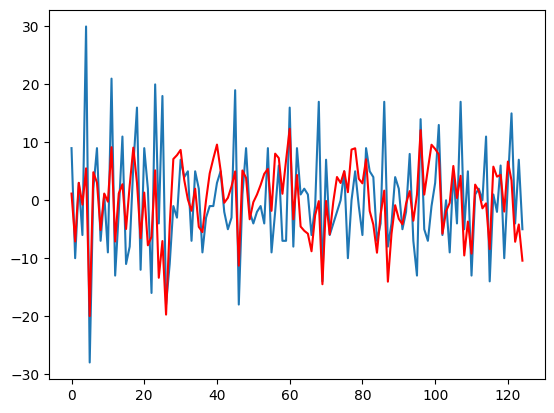

In [9]:
# autoregressive model of residual errors
from statsmodels.tsa.ar_model import AutoReg
# create lagged dataset
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
# split into trian and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i] - train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 15
model = AutoReg(train_resid, window)
model_fit = model.fit()
coef = model_fit.params
print(f'Coef={coef}')
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
  # persistence
  yhat = test_X[t]
  error = test_y[t] - yhat
  expected_error.append(error)
  # predict error
  length = len(history)
  lag = [history[i] for i in range(length-window, length)]
  pred_error = coef[0]
  for d in range(window):
    pred_error += coef[d+1] * lag[window-d-1]
  predictions.append(pred_error)
  history.append(error)
  print(f'predicted error={pred_error}, expected error={error}')
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

#### Correct Predictions with a Model of Residuals

With a good estimate of forecast error at a time step, we can make better predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model:

improved_forecast = forecast + estimated_error.

Let’s make this concrete with an example. Let’s say that the expected value for a time step is 10. The model predicts 8 and estimates the error to be 3. The improved forecast would be:
improved_forecast = forecast + estimated_error = 8 + 3 = 11.

This takes the actual forecast error from 2 units to 1 unit.

Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]
predicted=43.15552345054363, expected=51.0
predicted=43.89119067148697, expected=41.0
predicted=44.00748629526162, expected=44.0
predicted=43.24355434671727, expected=38.0
predicted=43.51116286306231, expected=68.0
predicted=48.008736410270075, expected=40.0
predicted=44.84242886199457, expected=42.0
predicted=45.05088305419858, expected=51.0
predicted=45.85841466120831, expected=44.0
predicted=45.16111915855918, expected=45.0
predicted=44.75807155568443, expected=36.0
predicted=45.15982604359748, expected=57.0
predicted=49.88202632611434, expected=44.0
predicted=45.18299217453099, expected=42.0
predicted=44.7693625826866, expected=53.0
predicted=48.040663356146254, expected=42.0
predicted=44.56623251498821, expected=34.0
predicted=43.084498380335276, expected=40.0
predicted=43.0208992067

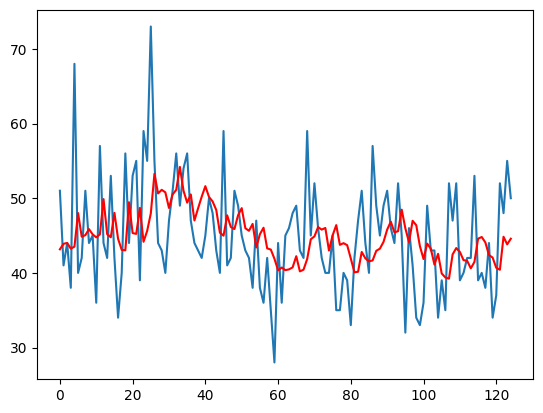

In [10]:
# correct forecasts with a model of forecast residual errors
from statsmodels.tsa.ar_model import AutoReg
# create lagged dataset
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
# split into trian and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i] - train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 15
model = AutoReg(train_resid, window)
model_fit = model.fit()
coef = model_fit.params
print(f'Coef={coef}')
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
  # persistence
  yhat = test_X[t]
  error = test_y[t] - yhat
  expected_error.append(error)
  # predict error
  length = len(history)
  lag = [history[i] for i in range(length-window, length)]
  pred_error = coef[0]
  for d in range(window):
    pred_error += coef[d+1] * lag[window-d-1]
  # correct the prediction
  yhat = yhat + pred_error
  predictions.append(yhat)
  history.append(error)
  print(f'predicted={yhat}, expected={test_y[t]}')
# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f'Test RMSE: {rmse:.3f}')
# plot predicted error
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()
